In [1]:
#Download Bitcoin historical data 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-03-25 19:31:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2022-03-25 19:31:07 (5.56 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [32]:
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) 
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [33]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"])
bitcoin_prices.rename(columns={'Closing Price (USD)': 'Price'}, inplace=True)


In [34]:
bitcoin_prices = bitcoin_prices.iloc[np.logical_and(bitcoin_prices.index >= "2013-04-01",
                                   bitcoin_prices.index <= "2020-04-20")]

prices = bitcoin_prices["Price"].values

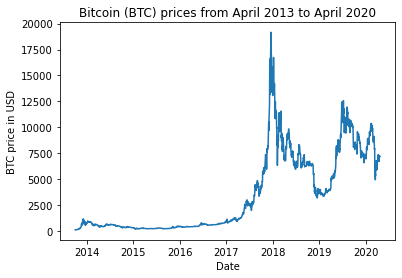

In [38]:
plt.title("Bitcoin (BTC) prices from April 2013 to April 2020")
plt.xlabel("Date")
plt.ylabel("BTC price in USD")
plt.plot(bitcoin_prices.index, prices)
plt.show()